In [1]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils import data
%matplotlib inline

Define dataset using torch

In [2]:
class TGSSaltDataset(data.Dataset):
    
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        
        return image, mask

# Import dataset

In [3]:
train_mask = pd.read_csv('data/train.csv')
depth = pd.read_csv('data/depths.csv')
train_path = "data/train/"

file_list = list(train_mask['id'].values)
dataset = TGSSaltDataset(train_path, file_list)

In [4]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

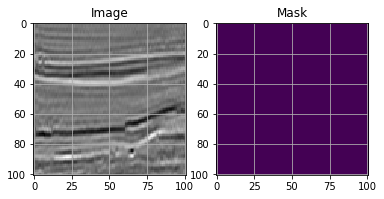

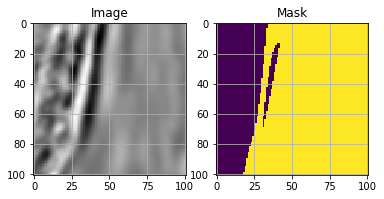

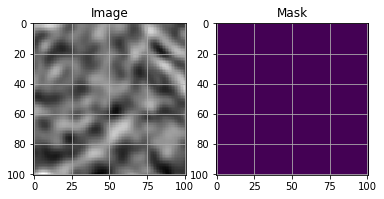

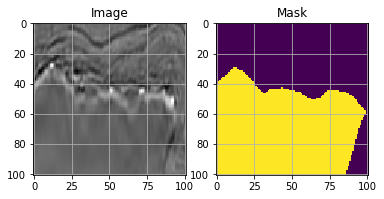

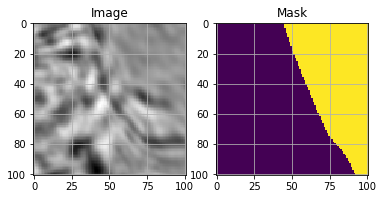

In [8]:
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2Array(image, mask)

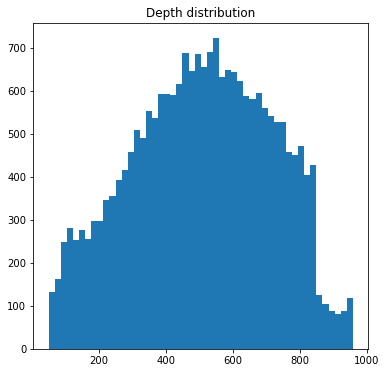

In [15]:
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins = 50)
plt.title('Depth distribution')